In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, \
                                    Flatten, Conv1D, MaxPooling1D, Dropout, \
                                    Concatenate, GlobalMaxPool1D, GlobalAvgPool1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_cnn(conv_num=1):
    filter_size = 32

    input_layer = Input(shape=input_shape)
    x = input_layer

    layer_outputs = []
    for i in range(conv_num):
        x = Conv1D (kernel_size=5, filters=filter_size*(2**(i//4)), 
                          strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling1D(pool_size=3, strides=3)(x)
        layer_outputs.append(x)    
    
    x = Concatenate()([Flatten()(output) for output in layer_outputs[-3:]])
    x = Dropout(0.5)(x)
    x = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=x)
    return model

In [9]:
for i in range(3, 9):
    model = build_cnn(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 16000, 32)    192         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 16000, 32)    128         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activatio

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 16000, 32)    192         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_7 (Batch (None, 16000, 32)    128         conv1d_7[0][0]                   
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 16000, 32)    0           batch_normalization_v1_7[0][0]   
__________________________________________________________________________________________________
max_poolin

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 16000, 32)    192         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_18 (Batc (None, 16000, 32)    128         conv1d_18[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 16000, 32)    0           batch_normalization_v1_18[0][0]  
__________________________________________________________________________________________________
max_poolin

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5614 - acc: 0.3341
Epoch 00001: val_loss improved from inf to 1.99982, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_32_DO_BN_3_conv_checkpoint/001-1.9998.hdf5
36805/36805 [==============================] - 34s 923us/sample - loss: 2.5614 - acc: 0.3341 - val_loss: 1.9998 - val_acc: 0.4072
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4455 - acc: 0.5683
Epoch 00002: val_loss improved from 1.99982 to 1.93119, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_32_DO_BN_3_conv_checkpoint/002-1.9312.hdf5
36805/36805 [==============================] - 32s 861us/sample - loss: 1.4454 - acc: 0.5683 - val_loss: 1.9312 - val_acc: 0.4598
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0327 - acc: 0.6761
Epoch 00003: val_loss did not i

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1485 - acc: 0.9556
Epoch 00028: val_loss did not improve from 1.75730
36805/36805 [==============================] - 31s 847us/sample - loss: 0.1485 - acc: 0.9556 - val_loss: 2.3700 - val_acc: 0.6129
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1415 - acc: 0.9570
Epoch 00029: val_loss did not improve from 1.75730
36805/36805 [==============================] - 31s 848us/sample - loss: 0.1415 - acc: 0.9570 - val_loss: 2.8935 - val_acc: 0.5737
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1262 - acc: 0.9624
Epoch 00030: val_loss did not improve from 1.75730
36805/36805 [==============================] - 31s 849us/sample - loss: 0.1262 - acc: 0.9625 - val_loss: 2.3900 - val_acc: 0.6145
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1247 - acc: 0.9639
Epoch 00031: val_loss did not improve from 1.75730
36805/36805 [=====

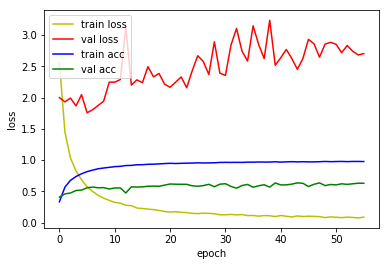

4815/4815 [==============================] - 2s 393us/sample - loss: 1.9066 - acc: 0.5223
Loss: 1.9066379495870287 Accuracy: 0.52232605

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4339 - acc: 0.3299
Epoch 00001: val_loss improved from inf to 1.98249, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_32_DO_BN_4_conv_checkpoint/001-1.9825.hdf5
36805/36805 [==============================] - 33s 899us/sample - loss: 2.4338 - acc: 0.3299 - val_loss: 1.9825 - val_acc: 0.3655
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5320 - acc: 0.5347
Epoch 00002: val_loss improved from 1.98249 to 1.34411, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_32_DO_BN_4_conv_checkpoint/002-1.3441.hdf5
36805/36805 [==============================] - 29s 795us/sample - loss: 1.5321 - acc: 0.5347 - val_loss: 1.3441 - val_acc: 0.5903
Epoch 3/500
36800/36805 [=============

36800/36805 [============================>.] - ETA: 0s - loss: 0.1580 - acc: 0.9489
Epoch 00028: val_loss did not improve from 1.23553
36805/36805 [==============================] - 29s 795us/sample - loss: 0.1580 - acc: 0.9489 - val_loss: 1.5510 - val_acc: 0.6788
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1448 - acc: 0.9540
Epoch 00029: val_loss did not improve from 1.23553
36805/36805 [==============================] - 29s 792us/sample - loss: 0.1448 - acc: 0.9541 - val_loss: 1.4796 - val_acc: 0.6897
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1490 - acc: 0.9520
Epoch 00030: val_loss did not improve from 1.23553
36805/36805 [==============================] - 29s 793us/sample - loss: 0.1490 - acc: 0.9519 - val_loss: 1.6395 - val_acc: 0.6778
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1434 - acc: 0.9533
Epoch 00031: val_loss did not improve from 1.23553
36805/36805 [==================

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0703 - acc: 0.9774
Epoch 00058: val_loss did not improve from 1.23553
36805/36805 [==============================] - 29s 796us/sample - loss: 0.0703 - acc: 0.9774 - val_loss: 1.4849 - val_acc: 0.7326
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0713 - acc: 0.9774
Epoch 00059: val_loss did not improve from 1.23553
36805/36805 [==============================] - 29s 791us/sample - loss: 0.0713 - acc: 0.9774 - val_loss: 1.6546 - val_acc: 0.7130
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0807 - acc: 0.9749
Epoch 00060: val_loss did not improve from 1.23553
36805/36805 [==============================] - 29s 795us/sample - loss: 0.0810 - acc: 0.9749 - val_loss: 1.5804 - val_acc: 0.7109
Epoch 61/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0751 - acc: 0.9770
Epoch 00061: val_loss did not improve from 1.23553
36805/36805 [=====

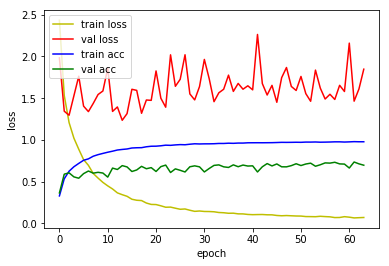

4815/4815 [==============================] - 2s 405us/sample - loss: 1.2882 - acc: 0.6754
Loss: 1.288201423696516 Accuracy: 0.6753894

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4125 - acc: 0.3157
Epoch 00001: val_loss improved from inf to 1.64657, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_32_DO_BN_5_conv_checkpoint/001-1.6466.hdf5
36805/36805 [==============================] - 36s 986us/sample - loss: 2.4127 - acc: 0.3157 - val_loss: 1.6466 - val_acc: 0.4500
Epoch 2/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.5323 - acc: 0.5297
Epoch 00002: val_loss improved from 1.64657 to 1.16508, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_32_DO_BN_5_conv_checkpoint/002-1.1651.hdf5
36805/36805 [==============================] - 31s 830us/sample - loss: 1.5317 - acc: 0.5298 - val_loss: 1.1651 - val_acc: 0.6408
Epoch 3/500
36800/36805 [===============

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3063 - acc: 0.9014
Epoch 00027: val_loss did not improve from 0.69388
36805/36805 [==============================] - 30s 824us/sample - loss: 0.3063 - acc: 0.9014 - val_loss: 0.8223 - val_acc: 0.7813
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2851 - acc: 0.9078
Epoch 00028: val_loss did not improve from 0.69388
36805/36805 [==============================] - 30s 827us/sample - loss: 0.2851 - acc: 0.9078 - val_loss: 0.8491 - val_acc: 0.7787
Epoch 29/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2892 - acc: 0.9060
Epoch 00029: val_loss did not improve from 0.69388
36805/36805 [==============================] - 30s 822us/sample - loss: 0.2892 - acc: 0.9060 - val_loss: 0.8134 - val_acc: 0.7929
Epoch 30/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2727 - acc: 0.9120
Epoch 00030: val_loss improved from 0.69388 to 0.68916, saving model 

36736/36805 [============================>.] - ETA: 0s - loss: 0.1379 - acc: 0.9558
Epoch 00055: val_loss did not improve from 0.67312
36805/36805 [==============================] - 30s 826us/sample - loss: 0.1381 - acc: 0.9557 - val_loss: 0.8328 - val_acc: 0.8046
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1472 - acc: 0.9526
Epoch 00056: val_loss did not improve from 0.67312
36805/36805 [==============================] - 30s 825us/sample - loss: 0.1473 - acc: 0.9525 - val_loss: 0.8493 - val_acc: 0.8181
Epoch 57/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1368 - acc: 0.9565
Epoch 00057: val_loss did not improve from 0.67312
36805/36805 [==============================] - 30s 826us/sample - loss: 0.1369 - acc: 0.9565 - val_loss: 0.8045 - val_acc: 0.8078
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1325 - acc: 0.9576
Epoch 00058: val_loss did not improve from 0.67312
36805/36805 [==================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0911 - acc: 0.9708
Epoch 00084: val_loss did not improve from 0.66015
36805/36805 [==============================] - 30s 828us/sample - loss: 0.0911 - acc: 0.9708 - val_loss: 0.7872 - val_acc: 0.8293
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0898 - acc: 0.9719
Epoch 00085: val_loss did not improve from 0.66015
36805/36805 [==============================] - 30s 828us/sample - loss: 0.0899 - acc: 0.9719 - val_loss: 0.8573 - val_acc: 0.8153
Epoch 86/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0900 - acc: 0.9719
Epoch 00086: val_loss did not improve from 0.66015
36805/36805 [==============================] - 30s 827us/sample - loss: 0.0901 - acc: 0.9718 - val_loss: 0.7060 - val_acc: 0.8444
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0823 - acc: 0.9745
Epoch 00087: val_loss did not improve from 0.66015
36805/36805 [==================

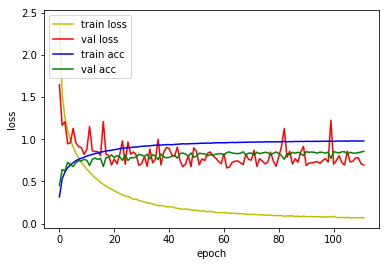

4815/4815 [==============================] - 2s 443us/sample - loss: 0.7644 - acc: 0.8154
Loss: 0.7643917271281329 Accuracy: 0.81536865

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2857 - acc: 0.3218
Epoch 00001: val_loss improved from inf to 1.87342, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_32_DO_BN_6_conv_checkpoint/001-1.8734.hdf5
36805/36805 [==============================] - 40s 1ms/sample - loss: 2.2858 - acc: 0.3218 - val_loss: 1.8734 - val_acc: 0.4009
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4960 - acc: 0.5277
Epoch 00002: val_loss improved from 1.87342 to 1.14352, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_32_DO_BN_6_conv_checkpoint/002-1.1435.hdf5
36805/36805 [==============================] - 32s 877us/sample - loss: 1.4960 - acc: 0.5278 - val_loss: 1.1435 - val_acc: 0.6504
Epoch 3/500
36800/36805 [===============

36800/36805 [============================>.] - ETA: 0s - loss: 0.2909 - acc: 0.9097
Epoch 00024: val_loss improved from 0.38850 to 0.35860, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_32_DO_BN_6_conv_checkpoint/024-0.3586.hdf5
36805/36805 [==============================] - 32s 865us/sample - loss: 0.2910 - acc: 0.9096 - val_loss: 0.3586 - val_acc: 0.9033
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2778 - acc: 0.9139
Epoch 00025: val_loss did not improve from 0.35860
36805/36805 [==============================] - 32s 863us/sample - loss: 0.2778 - acc: 0.9139 - val_loss: 0.3704 - val_acc: 0.8987
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2739 - acc: 0.9137
Epoch 00026: val_loss improved from 0.35860 to 0.34856, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_32_DO_BN_6_conv_checkpoint/026-0.3486.hdf5
36805/36805 [==============================] - 32s 867us/sample - loss: 0.2739 - ac

36800/36805 [============================>.] - ETA: 0s - loss: 0.1461 - acc: 0.9526
Epoch 00050: val_loss improved from 0.30035 to 0.29317, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_32_DO_BN_6_conv_checkpoint/050-0.2932.hdf5
36805/36805 [==============================] - 32s 869us/sample - loss: 0.1462 - acc: 0.9526 - val_loss: 0.2932 - val_acc: 0.9229
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1410 - acc: 0.9532
Epoch 00051: val_loss did not improve from 0.29317
36805/36805 [==============================] - 32s 857us/sample - loss: 0.1410 - acc: 0.9532 - val_loss: 0.3244 - val_acc: 0.9159
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1401 - acc: 0.9545
Epoch 00052: val_loss did not improve from 0.29317
36805/36805 [==============================] - 32s 860us/sample - loss: 0.1401 - acc: 0.9545 - val_loss: 0.4283 - val_acc: 0.8854
Epoch 53/500
36800/36805 [============================>.] - ETA: 0

Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0891 - acc: 0.9714
Epoch 00079: val_loss did not improve from 0.29110
36805/36805 [==============================] - 31s 849us/sample - loss: 0.0891 - acc: 0.9714 - val_loss: 0.3796 - val_acc: 0.9019
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0862 - acc: 0.9715
Epoch 00080: val_loss did not improve from 0.29110
36805/36805 [==============================] - 31s 848us/sample - loss: 0.0862 - acc: 0.9715 - val_loss: 0.3338 - val_acc: 0.9117
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0823 - acc: 0.9729
Epoch 00081: val_loss did not improve from 0.29110
36805/36805 [==============================] - 31s 845us/sample - loss: 0.0824 - acc: 0.9728 - val_loss: 0.3120 - val_acc: 0.9248
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0870 - acc: 0.9710
Epoch 00082: val_loss did not improve from 0.29110
36805/36805 [=====

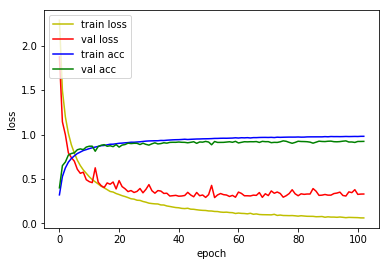

4815/4815 [==============================] - 2s 442us/sample - loss: 0.3543 - acc: 0.9018
Loss: 0.3543392738511134 Accuracy: 0.9017653

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4558 - acc: 0.2752
Epoch 00001: val_loss improved from inf to 1.69170, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_32_DO_BN_7_conv_checkpoint/001-1.6917.hdf5
36805/36805 [==============================] - 43s 1ms/sample - loss: 2.4559 - acc: 0.2753 - val_loss: 1.6917 - val_acc: 0.4200
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4958 - acc: 0.5218
Epoch 00002: val_loss improved from 1.69170 to 1.04447, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_32_DO_BN_7_conv_checkpoint/002-1.0445.hdf5
36805/36805 [==============================] - 33s 905us/sample - loss: 1.4958 - acc: 0.5218 - val_loss: 1.0445 - val_acc: 0.6792
Epoch 3/500
36800/36805 [================

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1991 - acc: 0.9368
Epoch 00024: val_loss did not improve from 0.23723
36805/36805 [==============================] - 33s 900us/sample - loss: 0.1991 - acc: 0.9369 - val_loss: 0.2638 - val_acc: 0.9266
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1896 - acc: 0.9415
Epoch 00025: val_loss did not improve from 0.23723
36805/36805 [==============================] - 33s 900us/sample - loss: 0.1897 - acc: 0.9415 - val_loss: 0.2397 - val_acc: 0.9371
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1826 - acc: 0.9425
Epoch 00026: val_loss did not improve from 0.23723
36805/36805 [==============================] - 33s 898us/sample - loss: 0.1826 - acc: 0.9425 - val_loss: 0.2608 - val_acc: 0.9287
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1767 - acc: 0.9451
Epoch 00027: val_loss improved from 0.23723 to 0.21369, saving model 

Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0909 - acc: 0.9709
Epoch 00052: val_loss improved from 0.20567 to 0.19189, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_32_DO_BN_7_conv_checkpoint/052-0.1919.hdf5
36805/36805 [==============================] - 33s 903us/sample - loss: 0.0909 - acc: 0.9709 - val_loss: 0.1919 - val_acc: 0.9476
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0871 - acc: 0.9722
Epoch 00053: val_loss did not improve from 0.19189
36805/36805 [==============================] - 33s 899us/sample - loss: 0.0871 - acc: 0.9722 - val_loss: 0.2529 - val_acc: 0.9390
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0836 - acc: 0.9733
Epoch 00054: val_loss did not improve from 0.19189
36805/36805 [==============================] - 33s 906us/sample - loss: 0.0836 - acc: 0.9733 - val_loss: 0.2113 - val_acc: 0.9467
Epoch 55/500
36800/36805 [===========================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0522 - acc: 0.9831
Epoch 00081: val_loss did not improve from 0.19189
36805/36805 [==============================] - 32s 864us/sample - loss: 0.0522 - acc: 0.9831 - val_loss: 0.2389 - val_acc: 0.9432
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0505 - acc: 0.9837
Epoch 00082: val_loss did not improve from 0.19189
36805/36805 [==============================] - 32s 862us/sample - loss: 0.0505 - acc: 0.9837 - val_loss: 0.2521 - val_acc: 0.9448
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0523 - acc: 0.9835
Epoch 00083: val_loss did not improve from 0.19189
36805/36805 [==============================] - 32s 857us/sample - loss: 0.0523 - acc: 0.9835 - val_loss: 0.2605 - val_acc: 0.9441
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0570 - acc: 0.9813
Epoch 00084: val_loss did not improve from 0.19189
36805/36805 [==================

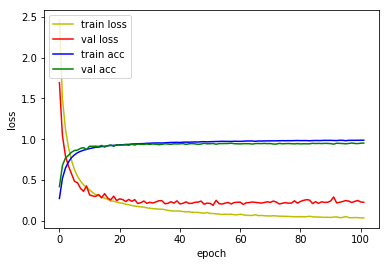

4815/4815 [==============================] - 2s 500us/sample - loss: 0.2457 - acc: 0.9325
Loss: 0.24573215460356398 Accuracy: 0.93250257

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6129 - acc: 0.2370
Epoch 00001: val_loss improved from inf to 1.76782, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_32_DO_BN_8_conv_checkpoint/001-1.7678.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 2.6128 - acc: 0.2370 - val_loss: 1.7678 - val_acc: 0.4379
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5610 - acc: 0.4987
Epoch 00002: val_loss improved from 1.76782 to 0.99925, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_32_DO_BN_8_conv_checkpoint/002-0.9993.hdf5
36805/36805 [==============================] - 34s 915us/sample - loss: 1.5610 - acc: 0.4987 - val_loss: 0.9993 - val_acc: 0.6897
Epoch 3/500
36800/36805 [==============

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1716 - acc: 0.9452
Epoch 00024: val_loss did not improve from 0.17298
36805/36805 [==============================] - 34s 919us/sample - loss: 0.1716 - acc: 0.9452 - val_loss: 0.1801 - val_acc: 0.9471
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1657 - acc: 0.9478
Epoch 00025: val_loss improved from 0.17298 to 0.15921, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_32_DO_BN_8_conv_checkpoint/025-0.1592.hdf5
36805/36805 [==============================] - 34s 930us/sample - loss: 0.1657 - acc: 0.9478 - val_loss: 0.1592 - val_acc: 0.9546
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1612 - acc: 0.9502
Epoch 00026: val_loss did not improve from 0.15921
36805/36805 [==============================] - 34s 926us/sample - loss: 0.1612 - acc: 0.9502 - val_loss: 0.1622 - val_acc: 0.9529
Epoch 27/500
36800/36805 [===========================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0696 - acc: 0.9774
Epoch 00052: val_loss did not improve from 0.14308
36805/36805 [==============================] - 34s 921us/sample - loss: 0.0696 - acc: 0.9774 - val_loss: 0.1909 - val_acc: 0.9469
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0719 - acc: 0.9769
Epoch 00053: val_loss did not improve from 0.14308
36805/36805 [==============================] - 34s 921us/sample - loss: 0.0719 - acc: 0.9769 - val_loss: 0.1466 - val_acc: 0.9588
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0654 - acc: 0.9781
Epoch 00054: val_loss did not improve from 0.14308
36805/36805 [==============================] - 34s 920us/sample - loss: 0.0655 - acc: 0.9781 - val_loss: 0.1502 - val_acc: 0.9583
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0676 - acc: 0.9776
Epoch 00055: val_loss did not improve from 0.14308
36805/36805 [==================

Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0380 - acc: 0.9879
Epoch 00082: val_loss did not improve from 0.14308
36805/36805 [==============================] - 34s 915us/sample - loss: 0.0380 - acc: 0.9879 - val_loss: 0.1558 - val_acc: 0.9595
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0364 - acc: 0.9884
Epoch 00083: val_loss did not improve from 0.14308
36805/36805 [==============================] - 34s 918us/sample - loss: 0.0365 - acc: 0.9883 - val_loss: 0.1603 - val_acc: 0.9557
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0403 - acc: 0.9864
Epoch 00084: val_loss did not improve from 0.14308
36805/36805 [==============================] - 34s 917us/sample - loss: 0.0403 - acc: 0.9864 - val_loss: 0.1727 - val_acc: 0.9534
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0337 - acc: 0.9896
Epoch 00085: val_loss did not improve from 0.14308
36805/36805 [=====

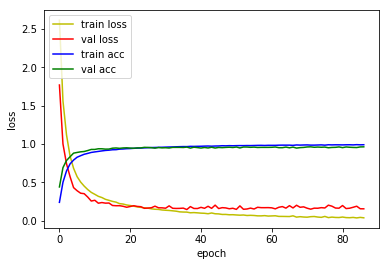

4815/4815 [==============================] - 3s 542us/sample - loss: 0.2036 - acc: 0.9377
Loss: 0.20359950304681268 Accuracy: 0.9376947



In [10]:
base = '1D_CNN_custom_multi_3_concat_ch_32_DO_BN'

for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    model = build_cnn(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_multi_3_concat_ch_32_DO_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 9):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_3_concat_ch_32_DO_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 32)    192         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_33 (Batc (None, 16000, 32)    128         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 32)    0           batch_normalization_v1_33[0][0]  
______________________________________________________

4815/4815 [==============================] - 2s 518us/sample - loss: 1.2882 - acc: 0.6754
Loss: 1.288201423696516 Accuracy: 0.6753894

1D_CNN_custom_multi_3_concat_ch_32_DO_BN_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 32)    192         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_40 (Batc (None, 16000, 32)    128         conv1d_40[0][0]                  
__________________________________________________________________________________________________
activation_40 (Acti

4815/4815 [==============================] - 3s 629us/sample - loss: 0.3543 - acc: 0.9018
Loss: 0.3543392738511134 Accuracy: 0.9017653

1D_CNN_custom_multi_3_concat_ch_32_DO_BN_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 32)    192         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_51 (Batc (None, 16000, 32)    128         conv1d_51[0][0]                  
__________________________________________________________________________________________________
activation_51 (Act

4815/4815 [==============================] - 3s 635us/sample - loss: 0.2036 - acc: 0.9377
Loss: 0.20359950304681268 Accuracy: 0.9376947


In [12]:
for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_custom_multi_3_concat_ch_32_DO_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 32)    192         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_33 (Batc (None, 16000, 32)    128         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 32)    0           batch_normalization_v1_33[0][0]  
______________________________________________________

4815/4815 [==============================] - 3s 677us/sample - loss: 2.0450 - acc: 0.6646
Loss: 2.0450161249590564 Accuracy: 0.6645898

1D_CNN_custom_multi_3_concat_ch_32_DO_BN_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 32)    192         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_40 (Batc (None, 16000, 32)    128         conv1d_40[0][0]                  
__________________________________________________________________________________________________
activation_40 (Act

4815/4815 [==============================] - 3s 671us/sample - loss: 0.4024 - acc: 0.9024
Loss: 0.4023934615518693 Accuracy: 0.9023884

1D_CNN_custom_multi_3_concat_ch_32_DO_BN_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 32)    192         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_51 (Batc (None, 16000, 32)    128         conv1d_51[0][0]                  
__________________________________________________________________________________________________
activation_51 (Act

4815/4815 [==============================] - 3s 673us/sample - loss: 0.2230 - acc: 0.9445
Loss: 0.22295345576627032 Accuracy: 0.9445483
